In [1]:
import os

from tqdm.autonotebook import tqdm, trange

from langchain_groq.chat_models import ChatGroq
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_core.tools import tool
from langchain_core.messages import ToolCall, ToolMessage
from langchain_core.agents import AgentAction

from typing import TypedDict, Annotated, List
from langchain_core.messages import BaseMessage
import operator

from langgraph.graph import StateGraph, END

from IPython.display import Image, display


from dotenv import load_dotenv, find_dotenv

# Load environment variables from.env file
load_dotenv(find_dotenv(), override=True)

os.chdir("../src")
print(os.getcwd())

from tools_agents.tools import (rag_search_filter,
                         rag_search,
                         fetch_abstract_from_arxiv,
                         web_search,
                         final_answer)

C:\Users\kamran\AppData\Local\Temp\ipykernel_12656\1425980433.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


e:\Github Repositories\Research-Assistant-LangGraph\src
Index langgraph-research-agent already exists.
Index Stats:
{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 4423}},
 'total_vector_count': 4423}


In [2]:
# Create a model
llm = ChatGroq(model="llama-3.1-70b-versatile",
                      stop_sequences="[end]",
                      temperature=0.)

In [3]:
# Define the system prompt guiding the AI's decision-making process.
system_prompt = (
    '''As the AI oracle, your primary role is to make informed decisions based on the user's query and the list of tools at your disposal.
    When processing a query, take note of the tools that have already been utilized in the scratchpad. 
    Avoid reusing a tool that has been previously applied to the same query. 
    Additionally, refrain from using any tool more than twice; if a tool has already appeared twice in the scratchpad, do not select it again.
    Your objective is to gather information from a wide range of sources before providing a response to the user. 
    Continue to collect and process data until you have accumulated sufficient information to answer the user's question. 
    Once you have compiled the necessary knowledge in the scratchpad, utilize the final_answer tool to provide a comprehensive response.
    Also keep track of different steps taken in terms of tools used in the scratchpad so that it can be used in research_steps in final respone from final_answer tool.
    The steps taken should be presented in a numbered list format in research_steps obtainef from the final_answer tool.
    Sources in the final_answer tool should also be mentioned in a numbered list format, mentioning the name and link if any of the sources.'''
)


# Create a prompt template for the conversation flow.
prompt = ChatPromptTemplate.from_messages([
    ('system', system_prompt),  # Define the AI's role and rules.
    
    # Insert past chat messages to maintain context.
    MessagesPlaceholder(variable_name='chat_history'),
    
    # Insert user's input dynamically.
    ('user', '{input}'),
    
    # Include the assistant's scratchpad to track tool usage and intermediate steps.
    ('assistant', 'scratchpad: {scratchpad}'),
])


In [4]:
# Define the list of tools available to the oracle.
tools = [
    rag_search_filter,
    rag_search,
    fetch_abstract_from_arxiv,
    web_search,
    final_answer
]

# Function to create the scratchpad from the intermediate tool calls.
def create_scratchpad(intermediate_steps: list[ToolCall]) -> str:
    research_steps = []
    
    # Loop over each step and process tool calls with actual outputs.
    for i, action in enumerate(intermediate_steps):
        if action.log != 'TBD':
            research_steps.append(
                f'Tool: {action.tool}, input: {action.tool_input}\n'
                f'Output: {action.log}'
            )
    
    # Join the research steps into a readable log.
    return '\n---\n'.join(research_steps)


oracle = (
    {
        'input': lambda x: x['input'],
        'chat_history': lambda x: x['chat_history'],
        'scratchpad': lambda x: create_scratchpad(intermediate_steps=x['intermediate_steps']),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice='any')
)



In [5]:
oracle

{
  input: RunnableLambda(...),
  chat_history: RunnableLambda(...),
  scratchpad: RunnableLambda(...)
}
| ChatPromptTemplate(input_variables=['chat_history', 'input', 'scratchpad'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')

In [6]:
# input = 'Tell me about natural language processing and large language models from arxiv?'
input = 'Where were olymics 2024 held?'
# input = 'What is the ArXiv paper with the ID 2401.04155v1 all about?'

inputs = {
    'input': input,
    'chat_history': [],
    'intermediate_steps': [],
}


out = oracle.invoke(inputs)

print(out)


content='' additional_kwargs={'tool_calls': [{'id': 'call_qtbt', 'function': {'arguments': '{"query": "Olympics 2024 location"}', 'name': 'web_search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 1443, 'total_tokens': 1461, 'completion_time': 0.072, 'prompt_time': 0.305066513, 'queue_time': 0.06989730999999999, 'total_time': 0.377066513}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_b3ae7e594e', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-de7a7190-ef2d-4d26-8d5c-a6a90341f6f6-0' tool_calls=[{'name': 'web_search', 'args': {'query': 'Olympics 2024 location'}, 'id': 'call_qtbt', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1443, 'output_tokens': 18, 'total_tokens': 1461}


In [7]:
out.tool_calls[0]['name'], out.tool_calls[0]['args']

('web_search', {'query': 'Olympics 2024 location'})

## Decision Making 

In [8]:
def run_oracle(state: dict) -> dict:
    print('run_oracle')
    print(f'intermediate_steps: {state["intermediate_steps"]}')
    print(state)
    
    out = oracle.invoke(state)
    print(out)

    tool_name = out.tool_calls[0]['name']
    tool_args = out.tool_calls[0]['args']

    print(f'tool_name: {tool_name}')
    print(f'tool_args: {tool_args}')

    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log='TBD'  # To be determined later after the tool runs.
    )

    return {'intermediate_steps': [action_out]}


# router() function
def router(state: dict) -> str:

    if isinstance(state['intermediate_steps'], list):
        print(f"running tool: {state['intermediate_steps'][-1].tool}")
        return state['intermediate_steps'][-1].tool
    else:
        print('Router invalid format')
        return 'final_answer'


tool_str_to_func = {
    'rag_search_filter': rag_search_filter,
    'rag_search': rag_search,
    'fetch_abstract_from_arxiv': fetch_abstract_from_arxiv,
    'web_search': web_search,
    'final_answer': final_answer
}

# The run_tool() function executes the appropriate tool based on the current state.
def run_tool(state: dict) -> dict:

    tool_name = state['intermediate_steps'][-1].tool
    tool_args = state['intermediate_steps'][-1].tool_input

    print(f'{tool_name}.invoke(input={tool_args})')

    out = tool_str_to_func[tool_name].invoke(input=tool_args)

    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )

    return {'intermediate_steps': [action_out]}

## Building the Graph

In [9]:
class AgentState(TypedDict):
    input: str
    chat_history: List[BaseMessage]
    intermediate_steps: Annotated[List[tuple[AgentAction, str]], operator.add]

In [10]:
workflow = StateGraph(AgentState)

workflow.add_node('oracle', run_oracle)
workflow.add_node('rag_search', run_tool)
workflow.add_node('rag_search_filter', run_tool)
workflow.add_node('web_search', run_tool)
workflow.add_node('fetch_abstract_from_arxiv', run_tool)
workflow.add_node('final_answer', run_tool)


workflow.set_entry_point('oracle')
workflow.add_conditional_edges(source='oracle',
                               path=router)

for tool_object in tools:
    if tool_object.name != 'final_answer':
        workflow.add_edge(tool_object.name, 'oracle')

workflow.add_edge('final_answer', END)

graph = workflow.compile()

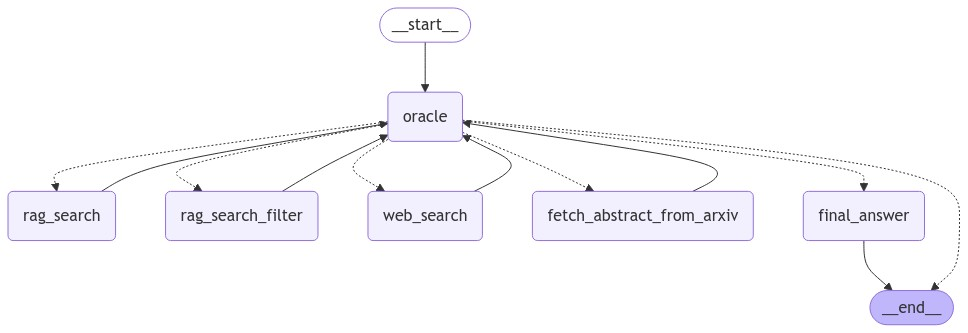

In [11]:

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
# output = graph.invoke({
#     'input': 'tell me about NLP and LLMs from rag?',
#     'chat_history': [],
# })

In [13]:
def build_report(output: dict) -> str:
    
    research_steps = output['research_steps']
    if isinstance(research_steps, list):
        research_steps = '\n'.join([f'- {r}' for r in research_steps])
    
    sources = output['sources']
    if isinstance(sources, list):
        sources = '\n'.join([f'- {s}' for s in sources])
    
    return f"""
        INTRODUCTION
        ------------
        {output['introduction']}
        
        RESEARCH STEPS
        --------------
        {research_steps}
        
        REPORT
        ------
        {output['main_body']}
        
        CONCLUSION
        ----------
        {output['conclusion']}
        
        SOURCES
        -------
        {sources}
    """


In [16]:
output = graph.invoke({
    'input': 'tell me about large language models in some detail?',
    'chat_history': [],
})

run_oracle
intermediate_steps: []
{'input': 'tell me about large language models in some detail?', 'chat_history': [], 'intermediate_steps': []}
content='' additional_kwargs={'tool_calls': [{'id': 'call_akqq', 'function': {'arguments': '{"query": "large language models"}', 'name': 'web_search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 2883, 'total_tokens': 2897, 'completion_time': 0.056, 'prompt_time': 0.57047439, 'queue_time': -0.643569309, 'total_time': 0.62647439}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_5c5d1b5cfb', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-aeea70e5-c2d5-4c5e-adc8-91e756144f35-0' tool_calls=[{'name': 'web_search', 'args': {'query': 'large language models'}, 'id': 'call_akqq', 'type': 'tool_call'}] usage_metadata={'input_tokens': 2883, 'output_tokens': 14, 'total_tokens': 2897}
tool_name: web_search
tool_args: {'query': 'large language models'}
running tool: web_sear

In [17]:
print(build_report(output['intermediate_steps'][-1].tool_input ))


        INTRODUCTION
        ------------
        Large language models (LLMs) have recently demonstrated remarkable capabilities in natural language processing tasks and beyond. This success of LLMs has led to a large influx of research contributions in this direction. These works encompass diverse topics such as architectural innovations, better training strategies, context length improvements, fine-tuning, multi-modal LLMs, robotics
        
        RESEARCH STEPS
        --------------
        [1] Web search to gather information on large language models
        
        REPORT
        ------
        Large language models are a category of foundation models trained on immense amounts of data making them capable of understanding and generating natural language and other types of content to perform a wide range of tasks. They have become a household name thanks to the role they have played in bringing generative AI to the forefront of the public interest, as well as the point on whi